In [1]:
import pandas as pd
import numpy as np
import SVARIV
from tqdm import tqdm

# Load the data

In [2]:
#parameters 
p = 24 #lags
n = 3 #endog variables
nvar = 1 #test over the first one

In [3]:
X = pd.read_excel('./data/Oil/Data.xls', header=None)
X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p+1)], axis=1)
X = X[p:, :] 
X = np.concatenate([np.ones((len(X),1)), X], axis=1)
Z = pd.read_excel('./data/Oil/ExtIV.xls', header=None).values[p:,:]
Y = pd.read_excel('./data/Oil/Data.xls', header=None).values[p:,:]

# ols estimation

In [4]:
ols_est = SVARIV.ols(Y, X)
eta = ols_est['errors']

Get the $\hat{W}$, wald and $\hat{\Gamma}$ using the independent variables, the instrument, the errors and the parameters. You can use help to know the function

In [5]:
help(SVARIV.get_gamma_wald)

Help on function get_gamma_wald in module SVARIV:

get_gamma_wald(X, Z, eta, p, n, nvar)
    Input:
        X = matrix of exogenous variables for ols estimation (np.array) 
        Z = matrix or vector of exog instruments (np.array)
        eta = matrix of errors (np.array)
        p = # of lags (scalar)
        n = # of endog (scalar)
        nvar = number of the endog variable to be use in the test
    output:
        WHat, wald, Gamma_hat



In [6]:
#this is the test of Wald and Gamma_hat (replication)
WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)
print('Gamma_hat estimated: ')
print(Gamma_hat)
print('Wald estimated: {}'.format(wald))

Gamma_hat estimated: 
[[ 3.11805486]
 [ 0.11519854]
 [-0.43655489]]
Wald estimated: 4.398794075970551


# Impulse response

Using the $\hat{\beta}$ of the model you an estimate the impulse reponse. In this case, the function allow a covariance matrix of errors or $\hat{\Gamma}$. It will recoginze which one it is with the size of the matrix. See help of the function.


In [7]:
help(SVARIV.irf_lineal_cholesky)

Help on function irf_lineal_cholesky in module SVARIV:

irf_lineal_cholesky(betas, S, periods=21, normalize=True, cumulative=True)
    Input:
        betas = array in the order of the model (np.array)
        S = is a covariance matrix (np.array) 
            if S has shape nx1 it will asume that S = Gamma_hat
        normalize=True will normalize to the shock to be 1 default=True
        cumulative=True will accumulate the irf response default=True
        periods = scalar with the number of periods to use in the irf default=21
    Output:
        irf = matrix of irf (np.array) with all irf for all endog variables
    Notice the shock is always over the first variable.



Recover the parameters of the estimation
Then take out the constants for every equation.
Get the covariance matrix


In [8]:
betas = ols_est['betas_hat'].T 
betas_lag = betas[:,1:] #recover the parameters of the estimation
omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors']) #covariance matrix

Get the impulse response using the cumulative and noncumulative impulse response to replicate Figure1

In [9]:
#irf with cholesky decomposition
irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False)
irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True)

#irf with Gamma_hat
irf_gamma = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=False)
irf_gamma_cum = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=True)


# Bootstrap procedure

## I presented a usual bootstraps for th estimations (not the presented in the paper)

I used the $\hat{\Gamma}$ estimator for the bootstrap procedure. 

## Is a job to be done to create the confidence set presented in the paper.





In [10]:
reps = 1000 #number of repetitions in the bootstrap
irf_gamma_b, irf_gamma_cum_b = np.zeros((21, n, reps)), np.zeros((21, n, reps))


#notice I did not fixed the seed in the random process (to be done)
for r in tqdm(range(reps)):
    random_pos = np.random.randint(0, len(Y), len(Y)) 
    ols_est_rand = SVARIV.ols(Y[random_pos], X[random_pos])
    eta_rand = ols_est_rand['errors']
    betas_rand = ols_est_rand['betas_hat'].T
    betas_lag_rand = betas_rand[:, 1:]
    omega_rand = (eta_rand.T @ eta_rand) / len(eta_rand)
    _, _, Gamma_hat_rand = SVARIV.get_gamma_wald(X[random_pos], Z[random_pos], eta_rand, p, n, nvar)
    irf_gamma_b[:, :, r] = SVARIV.irf_lineal_cholesky(betas_lag_rand, Gamma_hat_rand, cumulative=False)
    irf_gamma_cum_b[:, :, r] = SVARIV.irf_lineal_cholesky(betas_lag_rand, Gamma_hat_rand, cumulative=True)


100%|██████████| 1000/1000 [00:29<00:00, 33.81it/s]


In [11]:
conf = 68 #confidence set (figure 1 of the paper)

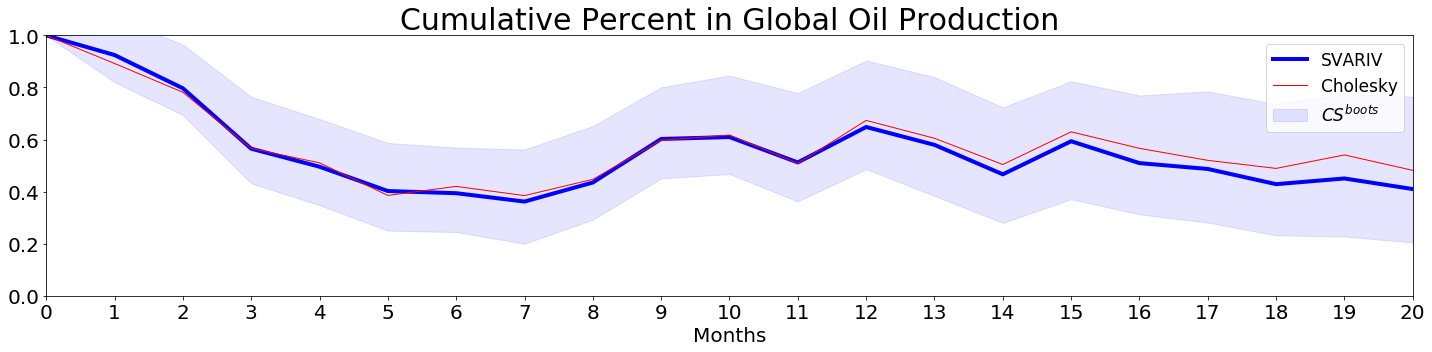

In [12]:
#plot Figure 1 (different confidence sets) Oil production
cs = np.sort(np.concatenate([irf_gamma_cum_b[:,:,i][:,0:1] for i in range(reps)], axis=1), axis=1)
cs = [[np.percentile(cs[i,:], (100-conf)/2) , np.percentile(cs[i,:], conf + (100-conf)/2)] for i in range(21)]
cs = np.array(cs)
fig11 = SVARIV.simple_plot('Cumulative Percent in Global Oil Production', 
                          irf_gamma_cum[:,0], irf_chol_cum[:,0], cs[:,0], cs[:,1],  
                          list(range(len(cs))), 
                          '', rot=0, ylim0=0, 
                          ylim1=1, figsize=(20,5))

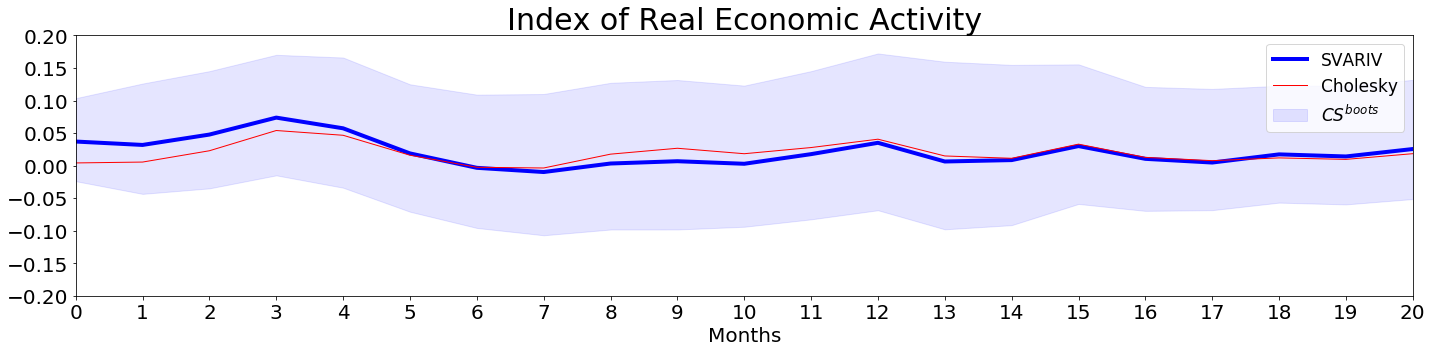

In [13]:
#plot Figure 1 (different confidence sets) index of real economic activity
cs = np.sort(np.concatenate([irf_gamma_b[:,:,i][:,1:2] for i in range(reps)], axis=1), axis=1)
cs = [[np.percentile(cs[i,:], (100-conf)/2) , np.percentile(cs[i,:], conf + (100-conf)/2)] for i in range(21)]
cs = np.array(cs)
fig12 = SVARIV.simple_plot('Index of Real Economic Activity', 
                          irf_gamma[:,1], irf_chol[:,1], cs[:,0], cs[:,1],  
                          list(range(len(cs))), 
                          '', rot=0, ylim0=-0.2, 
                          ylim1=0.2, figsize=(20,5))

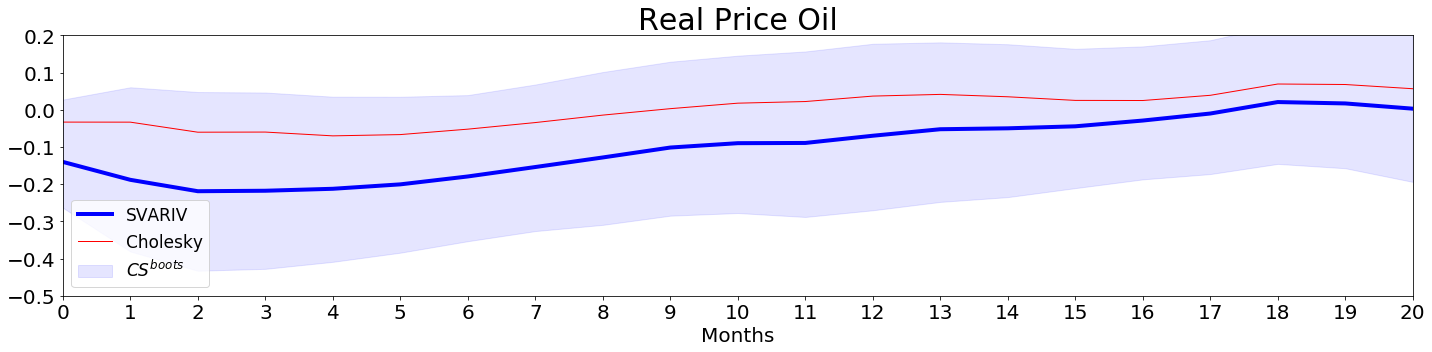

In [14]:
#plot Figure 1 (different confidence sets) Real Price of Oil
cs = np.sort(np.concatenate([irf_gamma_b[:,:,i][:,2:] for i in range(reps)], axis=1), axis=1)
cs = [[np.percentile(cs[i,:], (100-conf)/2) , np.percentile(cs[i,:], conf + (100-conf)/2)] for i in range(21)]
cs = np.array(cs)
fig13 = SVARIV.simple_plot('Real Price Oil', 
                          irf_gamma[:,2], irf_chol[:,2], cs[:,0], cs[:,1],  
                          list(range(len(cs))), 
                          '', rot=0, ylim0=-0.5, 
                          ylim1=0.2, figsize=(20,5))